In [39]:
# Thư viện xử lý dữ liệu dạng bảng
import pandas as pd

# Thư viện vẽ đồ thị dựa trên matplotlib
import seaborn as sns

# Thư viện thống kê
import scipy.stats as stats

# Import thư viện statsmodels để sử dụng module tương tác với mô hình hồi quy tuyến tính.
import statsmodels.api as sm

# Thư viện vẽ đồ thị
import matplotlib.pyplot as plt

In [40]:
# Thư viện statsmodels.formula.api hỗ trợ xây dựng mô hình tuyến tính
from statsmodels.formula.api import ols

# Sử dụng thư viện LabelEncoder để chuyển đổi biến phân loại thành dạng số
from sklearn.preprocessing import LabelEncoder

# 1.&nbsp;Đọc dữ liệu và xem thông tin

In [41]:
# Đọc dữ liệu từ file csv
df = pd.read_csv('../data/CarPricePrediction_Processed.csv')

In [42]:
# Liệt kê tên của các cột có trong bộ dữ liệu
df.columns

Index(['Màu sắc', 'Phân loại người bán', 'Tỉnh', 'Hãng', 'Dòng xe',
       'Năm sản xuất', 'Số Km đã đi', 'Tình trạng', 'Hộp số', 'Nhiên liệu',
       'Kiểu dáng', 'Số chỗ', 'Xuất xứ', 'Đối tác', 'Giá'],
      dtype='object')

In [43]:
# Hiển thị 5 dòng đầu tiên của bộ dữ liệu
df.head()

,Màu sắc,Phân loại người bán,Tỉnh,Hãng,Dòng xe,Năm sản xuất,Số Km đã đi,Tình trạng,Hộp số,Nhiên liệu,Kiểu dáng,Số chỗ,Xuất xứ,Đối tác,Giá
0,đen,Bán chuyên,Hà Nội,Mitsubishi,Xpander,2022,50000,Đã sử dụng,Tự động,Xăng,Minivan (MPV),7,Đang cập nhật,No,559000000
1,nâu,Cá nhân,Tp. Hồ Chí Minh,Nissan,Sunny,2019,52000,Đã sử dụng,Tự động,Xăng,Sedan,5,Hàn Quốc,No,335000000
2,đen,Cá nhân,Tp. Hồ Chí Minh,Ford,Escape,2003,50000,Đã sử dụng,Tự động,Xăng,SUV / Cross over,5,Việt Nam,No,106000000
3,đen,Cá nhân,Tp. Hồ Chí Minh,Hyundai,Accent,2021,42,Đã sử dụng,Tự động,Xăng,Sedan,4,Hàn Quốc,No,450000000
4,đỏ,Bán chuyên,Hà Nội,Ford,Ranger,2022,51000,Đã sử dụng,Tự động,Dầu,SUV / Cross over,5,Việt Nam,No,534000000


In [44]:
# Hiển thị thông tin bộ dữ liệu hiện tại
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Màu sắc              2685 non-null   object
 1   Phân loại người bán  2685 non-null   object
 2   Tỉnh                 2685 non-null   object
 3   Hãng                 2685 non-null   object
 4   Dòng xe              2685 non-null   object
 5   Năm sản xuất         2685 non-null   int64 
 6   Số Km đã đi          2685 non-null   int64 
 7   Tình trạng           2685 non-null   object
 8   Hộp số               2685 non-null   object
 9   Nhiên liệu           2685 non-null   object
 10  Kiểu dáng            2685 non-null   object
 11  Số chỗ               2685 non-null   int64 
 12  Xuất xứ              2685 non-null   object
 13  Đối tác              2685 non-null   object
 14  Giá                  2685 non-null   int64 
dtypes: int64(4), object(11)
memory usage: 314.8+ KB


In [45]:
# Tiếp theo, ta sẽ phân loại ra cho chúng là các biến số và biến phân loại.
# Đồng thời, lưu lại tên của biến mục tiêu
target_col = 'Giá'
numeric_cols = [column for column in df.columns if df[column].dtype !=
                'object' and column != 'Giá']
categories_cols = [
    column for column in df.columns if column not in numeric_cols and column != 'Giá']

# 2.&nbsp;Phân tích biến mục tiêu

Chúng tôi đã tiến hành vẽ biểu đồ Histogram và biểu đồ Boxplot cho biến mục tiêu là `Giá` để xem về phân phối của các giá trị trong biến này. Qua 2 biểu đồ trên, chúng tôi rút ra được một số nhận xét như sau:
- **Biểu đồ Histogram:** Ta có thể thấy rõ rằng tần suất của các mức giá tập trung nhiều nhất ở góc bên trái của biểu đồ do các cột ở vị trí đó là cao nhất cũng như đường cong KDE có đỉnh cũng tập trung tại vị trí đó.
- **Biểu đồ Boxplot:** Tương tự với Histogram, các khoảng giá cũng tập trung nhiều ở góc bên trái biểu đồ do đây là giá của các xe cũ nên mức giá thấp sẽ chiếm nhiều hơn các mức giá cao. Khoảng giá chiếm tần suất cao nhất là từ 318 triệu đồng đến 679 triệu đồng. Giá xe phổ biến nhất trong bộ dữ liệu là 476 triệu đồng.

In [46]:
def get_iqr_range_for_column(df, column_name):
    """
    Xuất khoảng IQR (Interquartile Range) của một cột trong DataFrame.

    Parameters:
    - df: DataFrame, DataFrame chứa dữ liệu.
    - column_name: str, Tên của cột cần xuất khoảng IQR.

    Returns:
    - tuple, Bao gồm giá trị Q1 và Q3.
    """

    # Lấy dữ liệu từ cột
    data = df[column_name]

    # Tính Q1 và Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    return Q1, Q3


def plot_histogram_and_boxplot(data, variable):
    """
    Vẽ hai biểu đồ histogram và boxplot bên cạnh nhau cho biến số.

    Parameters:
    - data: DataFrame, dữ liệu chứa biến số.
    - variable: str, tên biến số trong DataFrame.

    Returns:
    None (Hiển thị biểu đồ).
    """

    plt.figure(figsize=(12, 5))

    # Biểu đồ Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable], bins=30, kde=True,
                 color='skyblue', edgecolor='black')
    plt.title(f'Histogram - {variable}')
    plt.xlabel(variable)
    plt.ylabel('Tần suất')

    # Biểu đồ Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[variable], color='salmon')
    plt.title(f'Boxplot - {variable}')
    plt.xlabel(variable)

    plt.tight_layout()
    plt.show()

Giá xe có tần suất xuất hiện cao nhất là: 476000000.0
Khoảng giá có tần suất xuất hiện cao nhất là (318000000.0, 679000000.0)


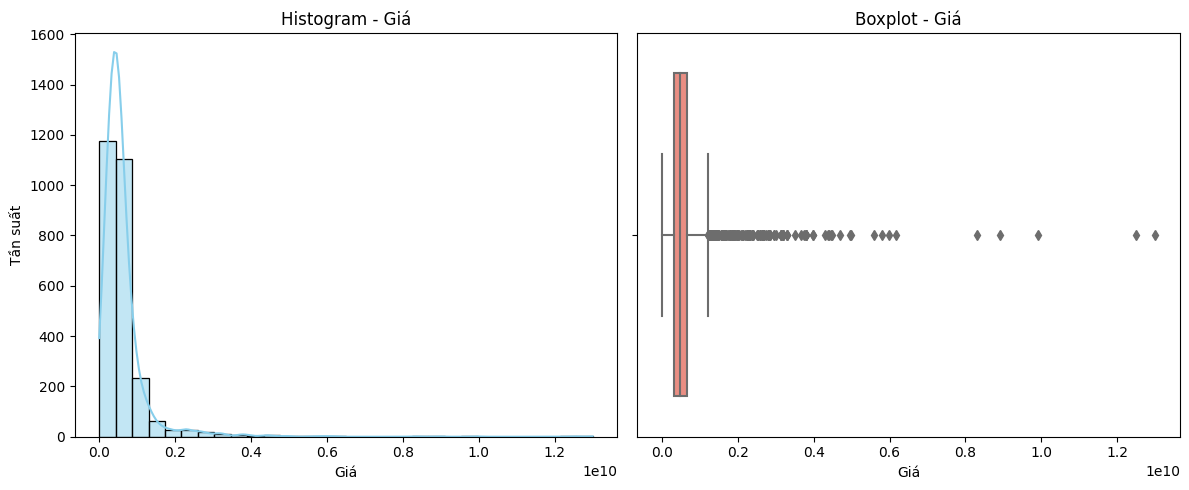

In [47]:
# Xem giá xuất hiện nhiều nhất (Q2) và khoảng phổ biến dựa vào IQR của "Giá"
Q2 = df[target_col].quantile(0.5)
IQR = get_iqr_range_for_column(df, target_col)
print(f"Giá xe có tần suất xuất hiện cao nhất là: {Q2}")
print(f"Khoảng giá có tần suất xuất hiện cao nhất là {IQR}")

# Vẽ biểu đồ histogram và boxplot cho biến "Giá"
plot_histogram_and_boxplot(df, target_col)

# 3.&nbsp;Phân tích biến số

## 3.1.&nbsp;Thống kê các số liệu cơ bản

In [48]:
# Tạo bảng thống kê tóm tắt về các biến số trong DataFrame bằng phương thức describe().
# Kết quả là một DataFrame với các chỉ số thống kê 
# như count, mean, std, min, 25%, 50%, 75%, và max.
# Chuyển vị DataFrame để hiển thị thông tin theo cột (biến số).
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Năm sản xuất,2685.0,2.016857e+03,5.559722e+00,1979.0,2014.0,2018.0,2021.0,2.023000e+03
Số Km đã đi,2685.0,5.339313e+04,3.221446e+04,4.0,28000.0,50000.0,80000.0,1.200000e+05
Số chỗ,2685.0,5.629050e+00,1.755610e+00,2.0,5.0,5.0,7.0,1.600000e+01
Giá,2685.0,6.198079e+08,7.191079e+08,5000000.0,318000000.0,476000000.0,679000000.0,1.300000e+10


## 3.2.&nbsp;Kiểm tra tính đối xứng

Nhận xét về tính đối xứng (với sai số 0.1) như sau:
- Các biến đối xứng: `Năm sản xuất` và `Số chỗ`
- Các biến không đối xứng: `Số Km đã đi` và `Giá`

In [49]:
def check_symmetry(column: pd.Series, tolerance_percent: float) -> bool:
    """
    Kiểm tra tính đối xứng của một cột thuộc tính với sai số cho trước.

    Parameters:
    - column: pd.Series, Cột thuộc tính cần kiểm tra.
    - tolerance_percent: float, Sai số cho phép (tính theo phần trăm).

    Returns:
    - bool, True nếu cột thuộc tính là đối xứng, False nếu không phải.
    """
    # Tính giá trị trung bình, trung vị và mode của cột thuộc tính.
    mean_value = column.mean()
    median_value = column.median()
    mode_values = column.mode()

    # Kiểm tra xem có một mode hay không, nếu có thì chỉ xét với mode[0].
    if len(mode_values) == 1:
        # Tính toán sai số theo phần trăm.
        mean_median_difference = abs(mean_value - median_value) / 100
        median_mode_difference = abs(median_value - mode_values[0]) / 100

        # Kiểm tra tính đối xứng với sai số cho trước.
        if mean_median_difference <= tolerance_percent and median_mode_difference <= tolerance_percent:
            return True

    # Nếu không có hoặc có nhiều hơn một mode, cột không đối xứng.
    return False


def create_symmetry_df(dataframe, numeric_columns, target_column=None, percent_threshold=0.1):
    """
    Tạo DataFrame chứa thông tin về đối xứng của các biến số kiểu số.

    Parameters:
    - dataframe: DataFrame, DataFrame chứa dữ liệu.
    - numeric_columns: list, Danh sách tên các biến kiểu số.
    - percent_threshold: float, Ngưỡng phần trăm sai số cho phép để coi là đối xứng.

    Returns:
    - DataFrame, DataFrame với tên biến số và cột đối xứng.
    """

    # Khởi tạo danh sách để lưu các DataFrame con.
    dfs = []

    # Duyệt qua từng biến số kiểu số trong danh sách.
    for column in numeric_columns:
        # Kiểm tra đối xứng và thêm vào danh sách.
        is_symmetric = check_symmetry(dataframe[column], percent_threshold)
        df = pd.DataFrame({'Tên biến': [column], 'Đối xứng?': [is_symmetric]})
        dfs.append(df)

    if target_column is not None:
        is_symmetric = check_symmetry(dataframe[target_column], percent_threshold)
        df = pd.DataFrame({'Tên biến': [target_column], 'Đối xứng?': [is_symmetric]})
        dfs.append(df)
        

    # Kết hợp tất cả các DataFrame con thành một DataFrame duy nhất.
    symmetry_df = pd.concat(dfs, ignore_index=True)

    return symmetry_df

In [50]:
# Tạo dataframe kiểm tra đối xứng cho các biến số với sai số là 0.1
create_symmetry_df(df, numeric_cols, target_col)

,Tên biến,Đối xứng?
0,Năm sản xuất,True
1,Số Km đã đi,False
2,Số chỗ,True
3,Giá,False


## 3.3.&nbsp;Biểu đồ tương quan

Dựa vào biểu đồ tương quan, ta thấy chỉ có giữa hai biến `Năm sản xuất` và `Số Km đã đi` là có tương quan nhưng là tương quan rất yếu (do nằm trong khoảng từ 0,3 đến 0,5). Do đó, ta có thể kết luận rằng giữa các biến số không có sự tương quan nào với nhau.

In [51]:
def correlation_plot(df, numeric_columns, target_column=None):
    """
    Tạo correlation plot cho các biến kiểu số trong DataFrame.

    Parameters:
    - df: DataFrame, DataFrame chứa dữ liệu.
    - numeric_columns: list, Danh sách các tên cột kiểu số.
    - target_column: str, Tên của cột giá muốn thêm vào.

    Returns:
    - None
    """
    # Chọn các cột kiểu số từ DataFrame.
    numeric_df = df.loc[:, numeric_columns].copy()

    # Kiểm tra xem có cột giá được chỉ định hay không.
    if target_column is not None and target_column in df.columns:
        # Nếu có, thêm cột giá vào DataFrame.
        numeric_df[target_column] = df[target_column]

    # Tính ma trận tương quan.
    correlation_matrix = numeric_df.corr()

    # Tạo correlation plot bằng seaborn.
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
    plt.title('Biểu đồ tương quan cho các biến kiểu số')
    plt.show()

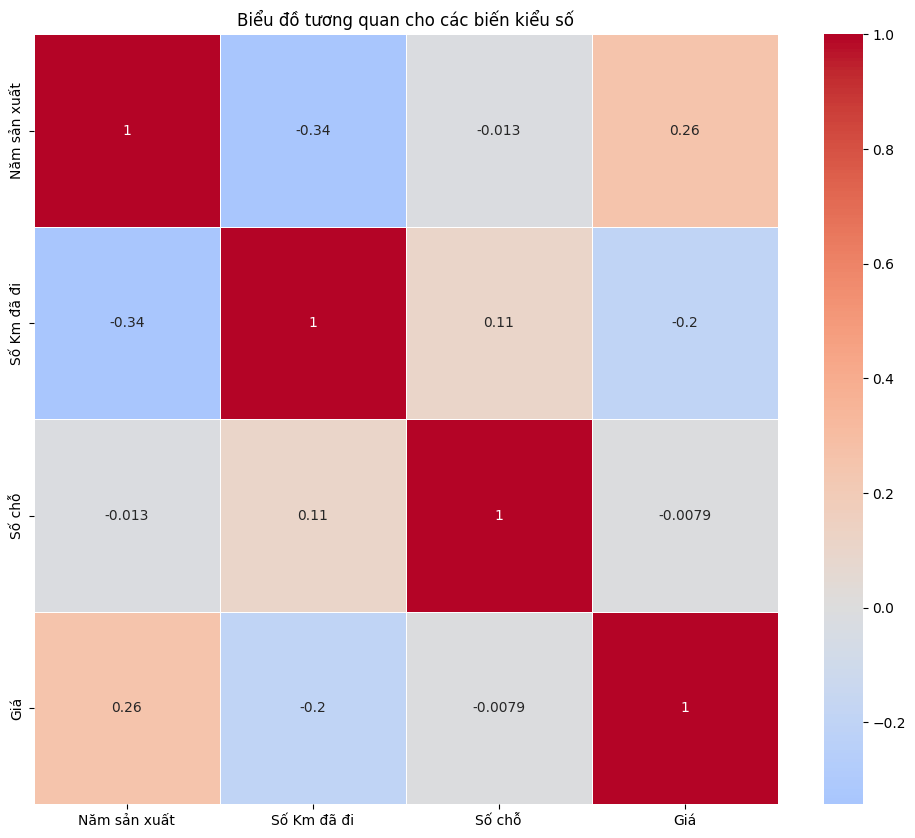

In [52]:
# Vẽ biểu đồ tương quan giữa các biến số
correlation_plot(df, numeric_cols, target_col)

## 3.4. Phân phối của các biến số

Chúng tôi đã tiến hành vẽ biểu đồ Boxplot và Histogram cho các biến số và rút ra được một số nhận xét như sau:
- **Năm sản xuất:** Những chiếc ô tô có số lượng nhiều nhất ở năm 2018 và nằm trong khoảng từ năm 2014 đến năm 2021.
- **Số Km đã đi:** Tập trung nhiều vào 50 nghìn km và nằm trong khoảng từ 28 nghìn km đến 80 nghìn km
- **Số chỗ:** Có số lượng nhiều nhất là 5 chỗ và nằm trong khoảng từ 5 đến 7 chỗ.

In [53]:
def boxplot_selected_variables(df, variable_list=None):
    """
    Vẽ boxplot cho các biến số được chọn trong DataFrame.

    Parameters:
    - df: DataFrame, DataFrame chứa dữ liệu.
    - variable_list: list, Danh sách tên các biến số cần vẽ boxplot. Nếu None, sẽ vẽ cho tất cả biến số kiểu số.

    Returns:
    - None (Hiển thị biểu đồ).
    """
    # Lấy danh sách các biến số kiểu số trong DataFrame.
    if variable_list is None:
        numeric_columns = df.select_dtypes(include='number').columns
    else:
        numeric_columns = variable_list

    # Thiết lập kích thước biểu đồ dựa trên số lượng biến số.
    plt.figure(figsize=(15, 6))

    # Vòng lặp để vẽ boxplot cho từng biến số.
    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(1, len(numeric_columns), i)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot - {col}')

    # Chỉnh layout để tránh chồng lấn.
    plt.tight_layout()
    
    # Hiển thị biểu đồ.
    plt.show()


def histogram_selected_variables(data, variables):
    """
    Vẽ histogram cho danh sách các biến số.

    Parameters:
    - data: DataFrame, Dữ liệu chứa các biến số.
    - variables: list, Danh sách tên các biến số cần vẽ histogram.

    Returns:
    - None (Hiển thị biểu đồ).
    """

    # Lấy danh sách các biến số kiểu số trong DataFrame.
    if variables is None:
        variables = df.select_dtypes(include='number').columns

    # Thiết lập kích thước biểu đồ dựa trên số lượng biến số.
    plt.figure(figsize=(15, 6))
    
    for i, var in enumerate(variables, 1):
        plt.subplot(1, len(variables), i)
        sns.histplot(data[var], kde=True)
        plt.title(f'Histogram cho {var}')
        plt.xlabel(var)
        plt.ylabel('Tần suất')

    # Chỉnh layout để tránh chồng lấn.
    plt.tight_layout()
    
    # Hiển thị biểu đồ.
    plt.show()

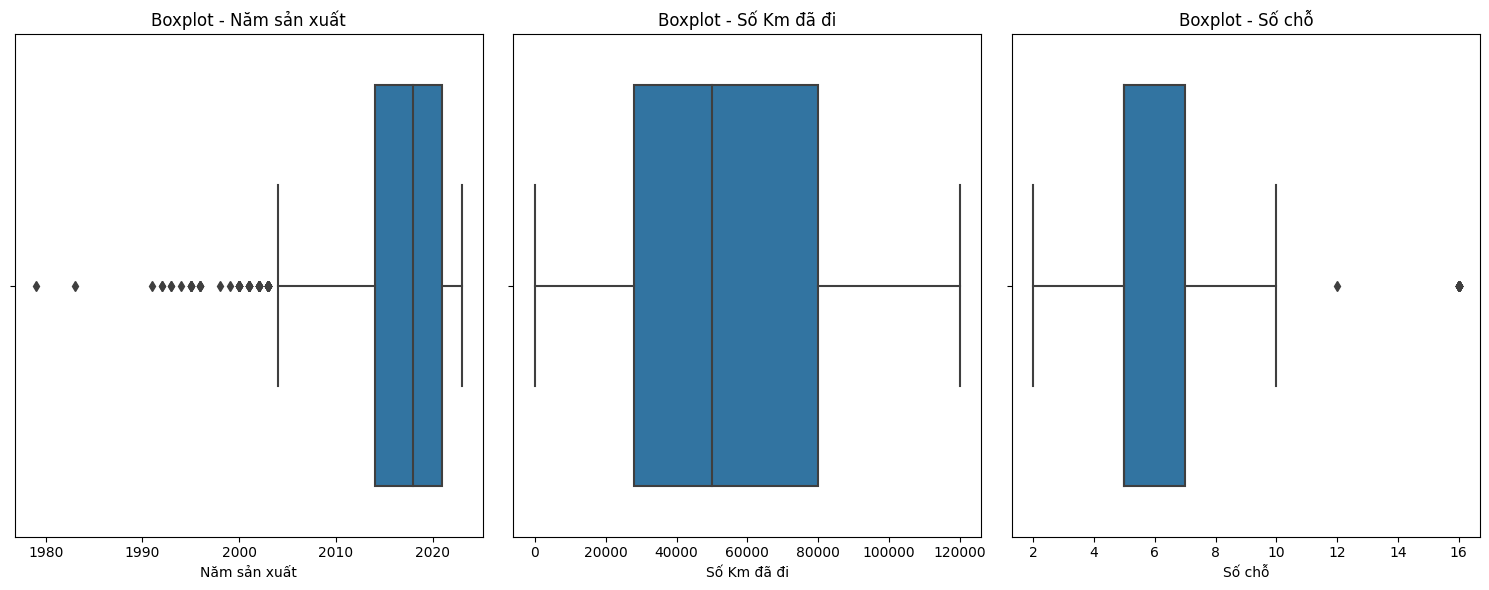

In [54]:
# Vẽ boxplot cho các biến số
boxplot_selected_variables(df, numeric_cols)

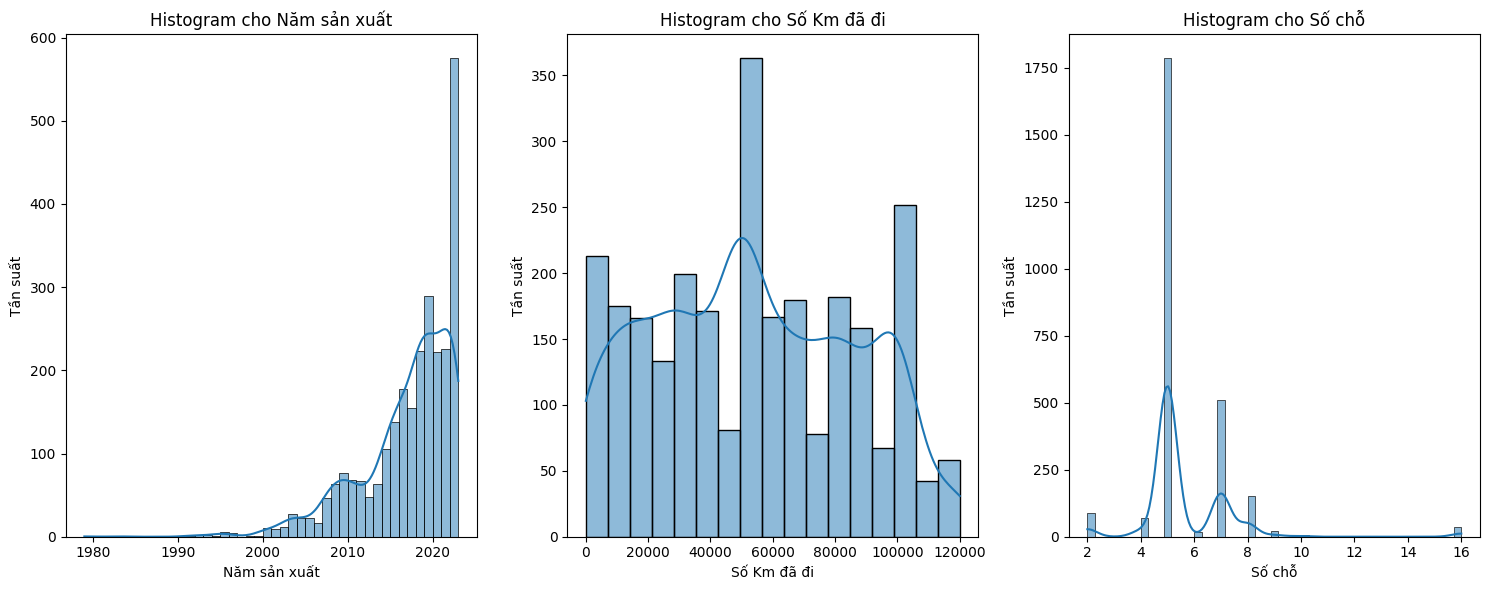

In [55]:
# Vẽ histogram và kde cho các biến số
histogram_selected_variables(df, numeric_cols)

## 3.5.&nbsp;Các biến số ảnh hưởng đến giá xe

Như thống kê bên dưới thì cả 3 biến `Năm sản xuất`, `Số Km đã đi` và `Số chỗ` đều không có ảnh hưởng đến giá xe.

In [56]:
def check_influence_level(series1: pd.Series, series2: pd.Series) -> int:
    """
    Kiểm tra mức độ ảnh hưởng giữa hai biến dựa trên hệ số tương quan và giá trị p.

    Tham số:
    - series1, series2: pd.Series, Hai Series cần kiểm tra.

    Trả về:
    - int, Mức độ ảnh hưởng: 0 (không ảnh hưởng), 1 (mạnh), 2 (trung bình), 3 (yếu).
    """
    # Tính hệ số tương quan và giá trị p giữa hai biến số.
    correlation_coefficient, p_value = stats.pearsonr(series1, series2)

    # Kiểm tra và đánh giá mức độ tương quan dựa trên hệ số và giá trị p.
    if p_value < 0.05:
        if 0.3 < abs(correlation_coefficient) <= 0.5:
            return 3  # Mức độ yếu
        elif 0.5 < abs(correlation_coefficient) <= 0.8:
            return 2  # Mức độ trung bình
        elif 0.8 < abs(correlation_coefficient) <= 1:
            return 1  # Mức độ mạnh

    return 0  # Không có ảnh hưởng


def find_influential_variables(df: pd.DataFrame, target_col: str, variable_list: list = None) -> pd.DataFrame:
    """
    Tìm tất cả các biến số ảnh hưởng đến biến mục tiêu và lưu vào DataFrame.

    Tham số:
    - df: pd.DataFrame, DataFrame chứa dữ liệu.
    - target_col: str, Tên cột biến mục tiêu.
    - variable_list: list, Danh sách tên các biến cần kiểm tra ảnh hưởng.

    Trả về:
    - pd.DataFrame, DataFrame chứa thông tin về mức độ ảnh hưởng của các biến.
    """
    # Kiểm tra nếu variable_list không được truyền vào, sử dụng tất cả các biến số kiểu số.
    if variable_list is None:
        variable_list = df.select_dtypes(include=['number']).columns.tolist()

    # Dictionary để lưu thông tin về mức độ ảnh hưởng của các biến.
    influence_dict = {'Tên biến': [], 'Mức độ ảnh hưởng': []}

    # Lặp qua từng biến số và kiểm tra ảnh hưởng.
    for col in variable_list:
        if col != target_col:
            influence_level = check_influence_level(df[col], df[target_col])
            influence_dict['Tên biến'].append(col)
            influence_dict['Mức độ ảnh hưởng'].append(influence_level)

    # Tạo DataFrame từ Dictionary.
    influence_df = pd.DataFrame(influence_dict)

    # Sắp xếp DataFrame theo mức độ ảnh hưởng tăng dần.
    influence_df = influence_df.sort_values(by='Mức độ ảnh hưởng')

    return influence_df

In [57]:
# Tìm tất cả các biến số có ảnh hưởng đến giá xe
find_influential_variables(df, target_col, numeric_cols)

,Tên biến,Mức độ ảnh hưởng
0,Năm sản xuất,0
1,Số Km đã đi,0
2,Số chỗ,0


# 4.&nbsp;Phân tích biến phân loại

## 4.1.&nbsp;Phân phối của các biến phân loại

Theo các biểu đồ mà chúng tôi vẽ được, chúng tôi có một số nhận xét như sau:
- `Màu sắc` nhiều nhất là đen, các màu còn lại chiếm số lượng không nhiều.
- `Phân loại người bán` nhiều nhất là Bán chuyên.
- `Tỉnh` bán xe nhiều nhất là Tp Hồ Chí Minh và Hà Nội.
- `Hãng` xuất hiện nhiều nhất là Toyota.
- `Dòng xe` nhiều nhất là Innova.
- `Tình trạng` chủ yếu là Đã sử dụng.
- `Hộp số` chủ yếu là Tự động.
- `Nhiên liệu` chủ yếu là Xăng.
- `Kiểu dáng` chủ yếu là Sedan.
- `Xuất xứ` chủ yếu là Việt Nam, nhiều xe vẫn còn Đang cập nhật.
- `Đối tác` thường là không có đối với các chủ xe.

In [58]:
def countplot_for_categorical_variable(data, column, figsize=(10, 6), ax=None):
    """
    Vẽ countplot cho biến phân loại trong 1 dataframe.

    Parameters:
    - data: DataFrame, dữ liệu cần vẽ.
    - column: str, tên cột biến phân loại.
    - figsize: tuple, kích thước của biểu đồ.
    - ax: matplotlib.axes._subplots.AxesSubplot, trục để vẽ countplot.

    Returns:
    - None
    """

    # Vẽ countplot.
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    sns.countplot(data=data, x=column,
                  order=data[column].value_counts().index, ax=ax)
    ax.set_title(f'Countplot - {column}')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel(f'Tần suất')


def countplot_for_all_categorical_variables(df: pd.DataFrame, categorical_columns_list: list = None, top_n: int = 10, cols_per_row: int = 2):
    """
    Vẽ countplot cho tất cả các biến phân loại và lưu thành hình ảnh.

    Tham số:
    - df: pd.DataFrame, DataFrame chứa dữ liệu.
    - categorical_columns_list: list, Danh sách các biến phân loại cần vẽ countplot. Nếu None, sẽ sử dụng tất cả các biến phân loại.
    - top_n: int, Số lượng giá trị xuất hiện nhiều nhất muốn hiển thị cho mỗi biến phân loại.
    - cols_per_row: int, Số lượng cột biểu đồ trên mỗi hàng.

    Trả về:
    - None
    """

    # Lấy danh sách các cột có kiểu dữ liệu là 'object' (biến phân loại).
    if categorical_columns_list is None:
        categorical_columns = df.select_dtypes(include=['object']).columns
    else:
        categorical_columns = categorical_columns_list

    # Tính số lượng hàng cần cho biểu đồ.
    num_rows = len(categorical_columns) // cols_per_row
    if len(categorical_columns) % cols_per_row != 0:
        num_rows += 1

    # Tạo lưới subplot với số lượng hàng và cột.
    fig, axes = plt.subplots(num_rows, cols_per_row,
                             figsize=(15, 4 * num_rows))

    # Lặp qua tất cả các cột và vẽ countplot cho mỗi cột.
    for idx, column in enumerate(categorical_columns):
        row = idx // cols_per_row
        col = idx % cols_per_row

        # Lấy top_n giá trị xuất hiện nhiều nhất.
        top_values = df[column].value_counts().nlargest(top_n).index

        # Tạo DataFrame mới với giá trị trong top_n và giá trị 'Khác'.
        data_filtered = df.copy()
        data_filtered[column] = df[column].where(
            df[column].isin(top_values), 'Khác')

        # Gọi hàm countplot_for_categorical_variable để vẽ biểu đồ.
        countplot_for_categorical_variable(
            data_filtered, column, ax=axes[row, col])

    # Tinh chỉnh layout của subplot.
    plt.tight_layout()
    plt.show()


def boxplot_for_categorical_variable(data, column, numeric_column, figsize=(10, 6), ax=None):
    """
    Vẽ boxplot cho biến phân loại trong 1 dataframe với một biến số.

    Parameters:
    - data: DataFrame, dữ liệu cần vẽ.
    - column: str, tên cột biến phân loại.
    - numeric_column: str, tên cột biến số.
    - figsize: tuple, kích thước của biểu đồ.
    - ax: matplotlib.axes._subplots.AxesSubplot, trục để vẽ countplot.

    Returns:
    - None
    """

    # Vẽ boxplot.
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    sns.boxplot(data=data, x=column, y=numeric_column,
                order=data[column].value_counts().index, ax=ax)
    ax.set_title(f'Boxplot - {column} được phân phối theo {numeric_column}')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel(numeric_column)


def boxplot_for_all_categorical_variables(df: pd.DataFrame, categorical_columns_list: list = None, target_col: str = 'Giá', top_n: int = 10, cols_per_row: int = 2):
    """
    Vẽ boxplot cho tất cả các biến phân loại và lưu thành hình ảnh.

    Tham số:
    - df: pd.DataFrame, DataFrame chứa dữ liệu.
    - categorical_columns_list: list, Danh sách các biến phân loại cần vẽ boxplot. Nếu None, sẽ sử dụng tất cả các biến phân loại.
    - target_col: str, Tên cột biến số cần vẽ boxplot (mặc định là 'Giá').
    - top_n: int, Số lượng giá trị xuất hiện nhiều nhất muốn hiển thị cho mỗi biến phân loại.
    - cols_per_row: int, Số lượng cột biểu đồ trên mỗi hàng.

    Trả về:
    - None
    """

    # Lấy danh sách các cột có kiểu dữ liệu là 'object' (biến phân loại).
    if categorical_columns_list is None:
        categorical_columns = df.select_dtypes(include=['object']).columns
    else:
        categorical_columns = categorical_columns_list

    # Tính số lượng hàng cần cho biểu đồ.
    num_rows = len(categorical_columns) // cols_per_row
    if len(categorical_columns) % cols_per_row != 0:
        num_rows += 1

    # Tạo lưới subplot với số lượng hàng và cột.
    fig, axes = plt.subplots(num_rows, cols_per_row,
                             figsize=(15, 4 * num_rows))

    # Lặp qua tất cả các cột và vẽ boxplot cho mỗi cột.
    for idx, column in enumerate(categorical_columns):
        row = idx // cols_per_row
        col = idx % cols_per_row

        # Lấy top_n giá trị xuất hiện nhiều nhất.
        top_values = df[column].value_counts().nlargest(top_n).index

        # Tạo DataFrame mới với giá trị trong top_n và giá trị 'Khác'.
        data_filtered = df.copy()
        data_filtered[column] = df[column].where(
            df[column].isin(top_values), 'Khác')

        # Gọi hàm boxplot_for_categorical_variable để vẽ biểu đồ.
        boxplot_for_categorical_variable(
            data_filtered, column, target_col, ax=axes[row, col])

    # Tinh chỉnh layout của subplot.
    plt.tight_layout()
    plt.show()

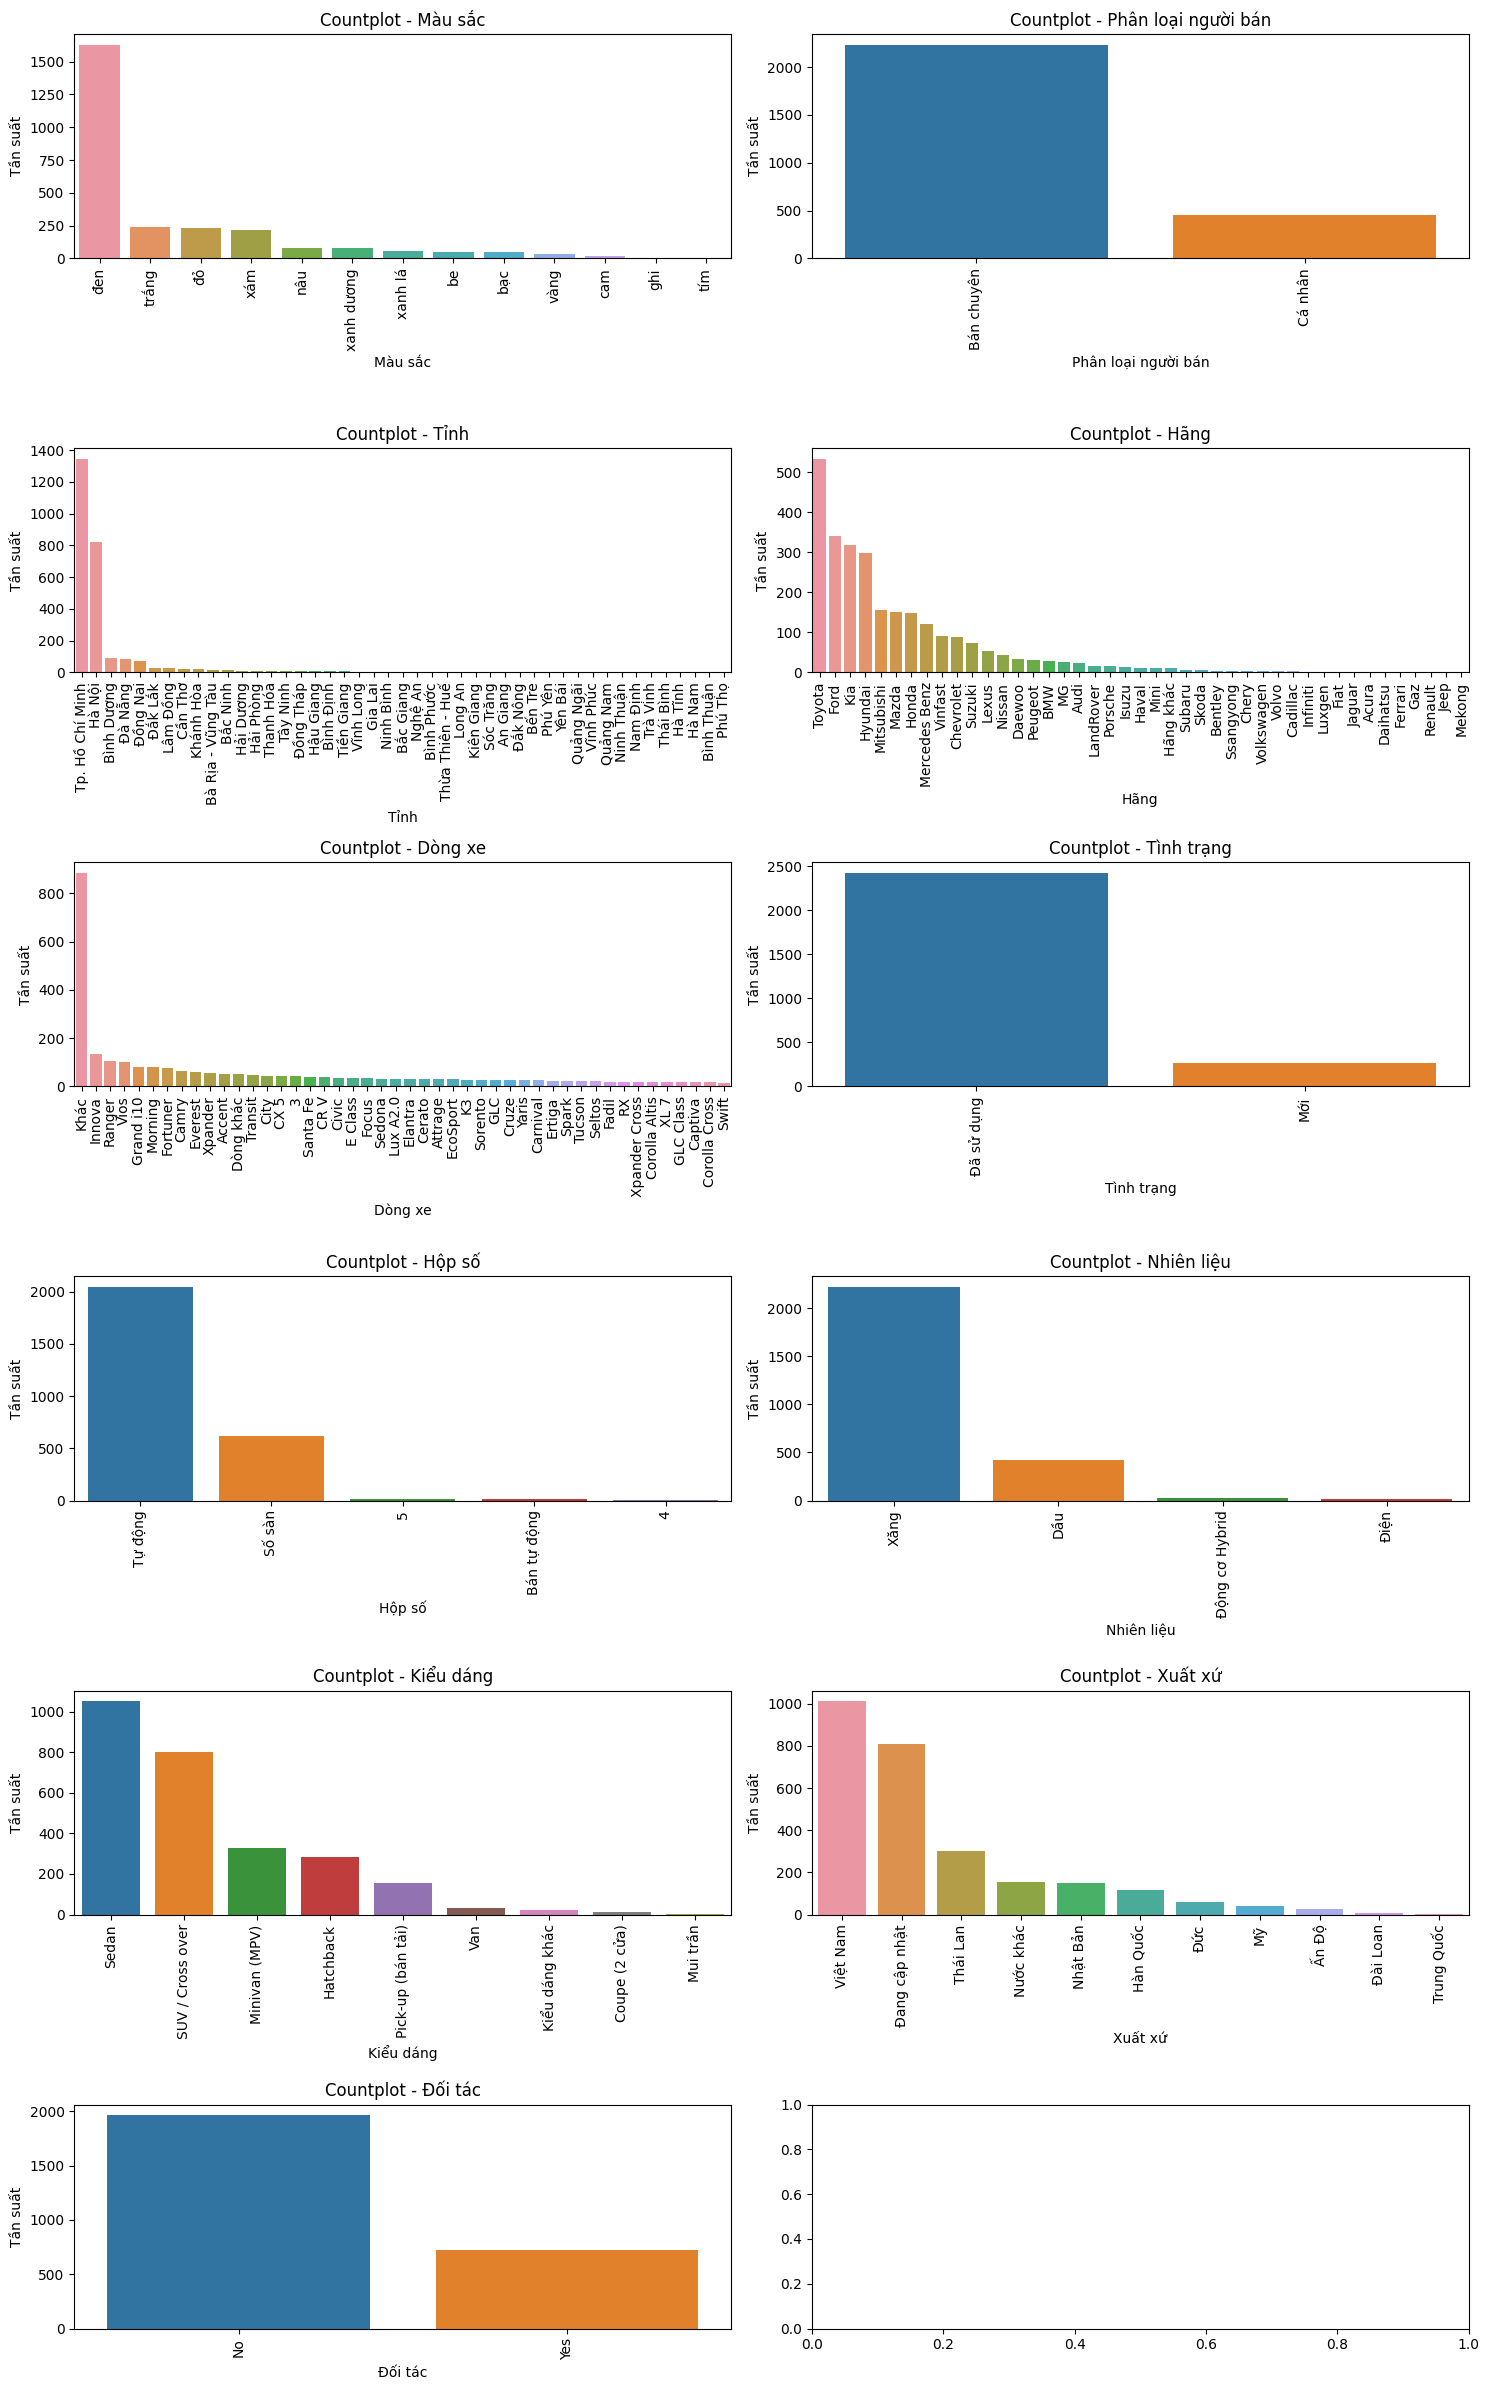

In [59]:
# Vẽ countplot cho tất cả các biến phân loại
countplot_for_all_categorical_variables(df, categories_cols, top_n=45)

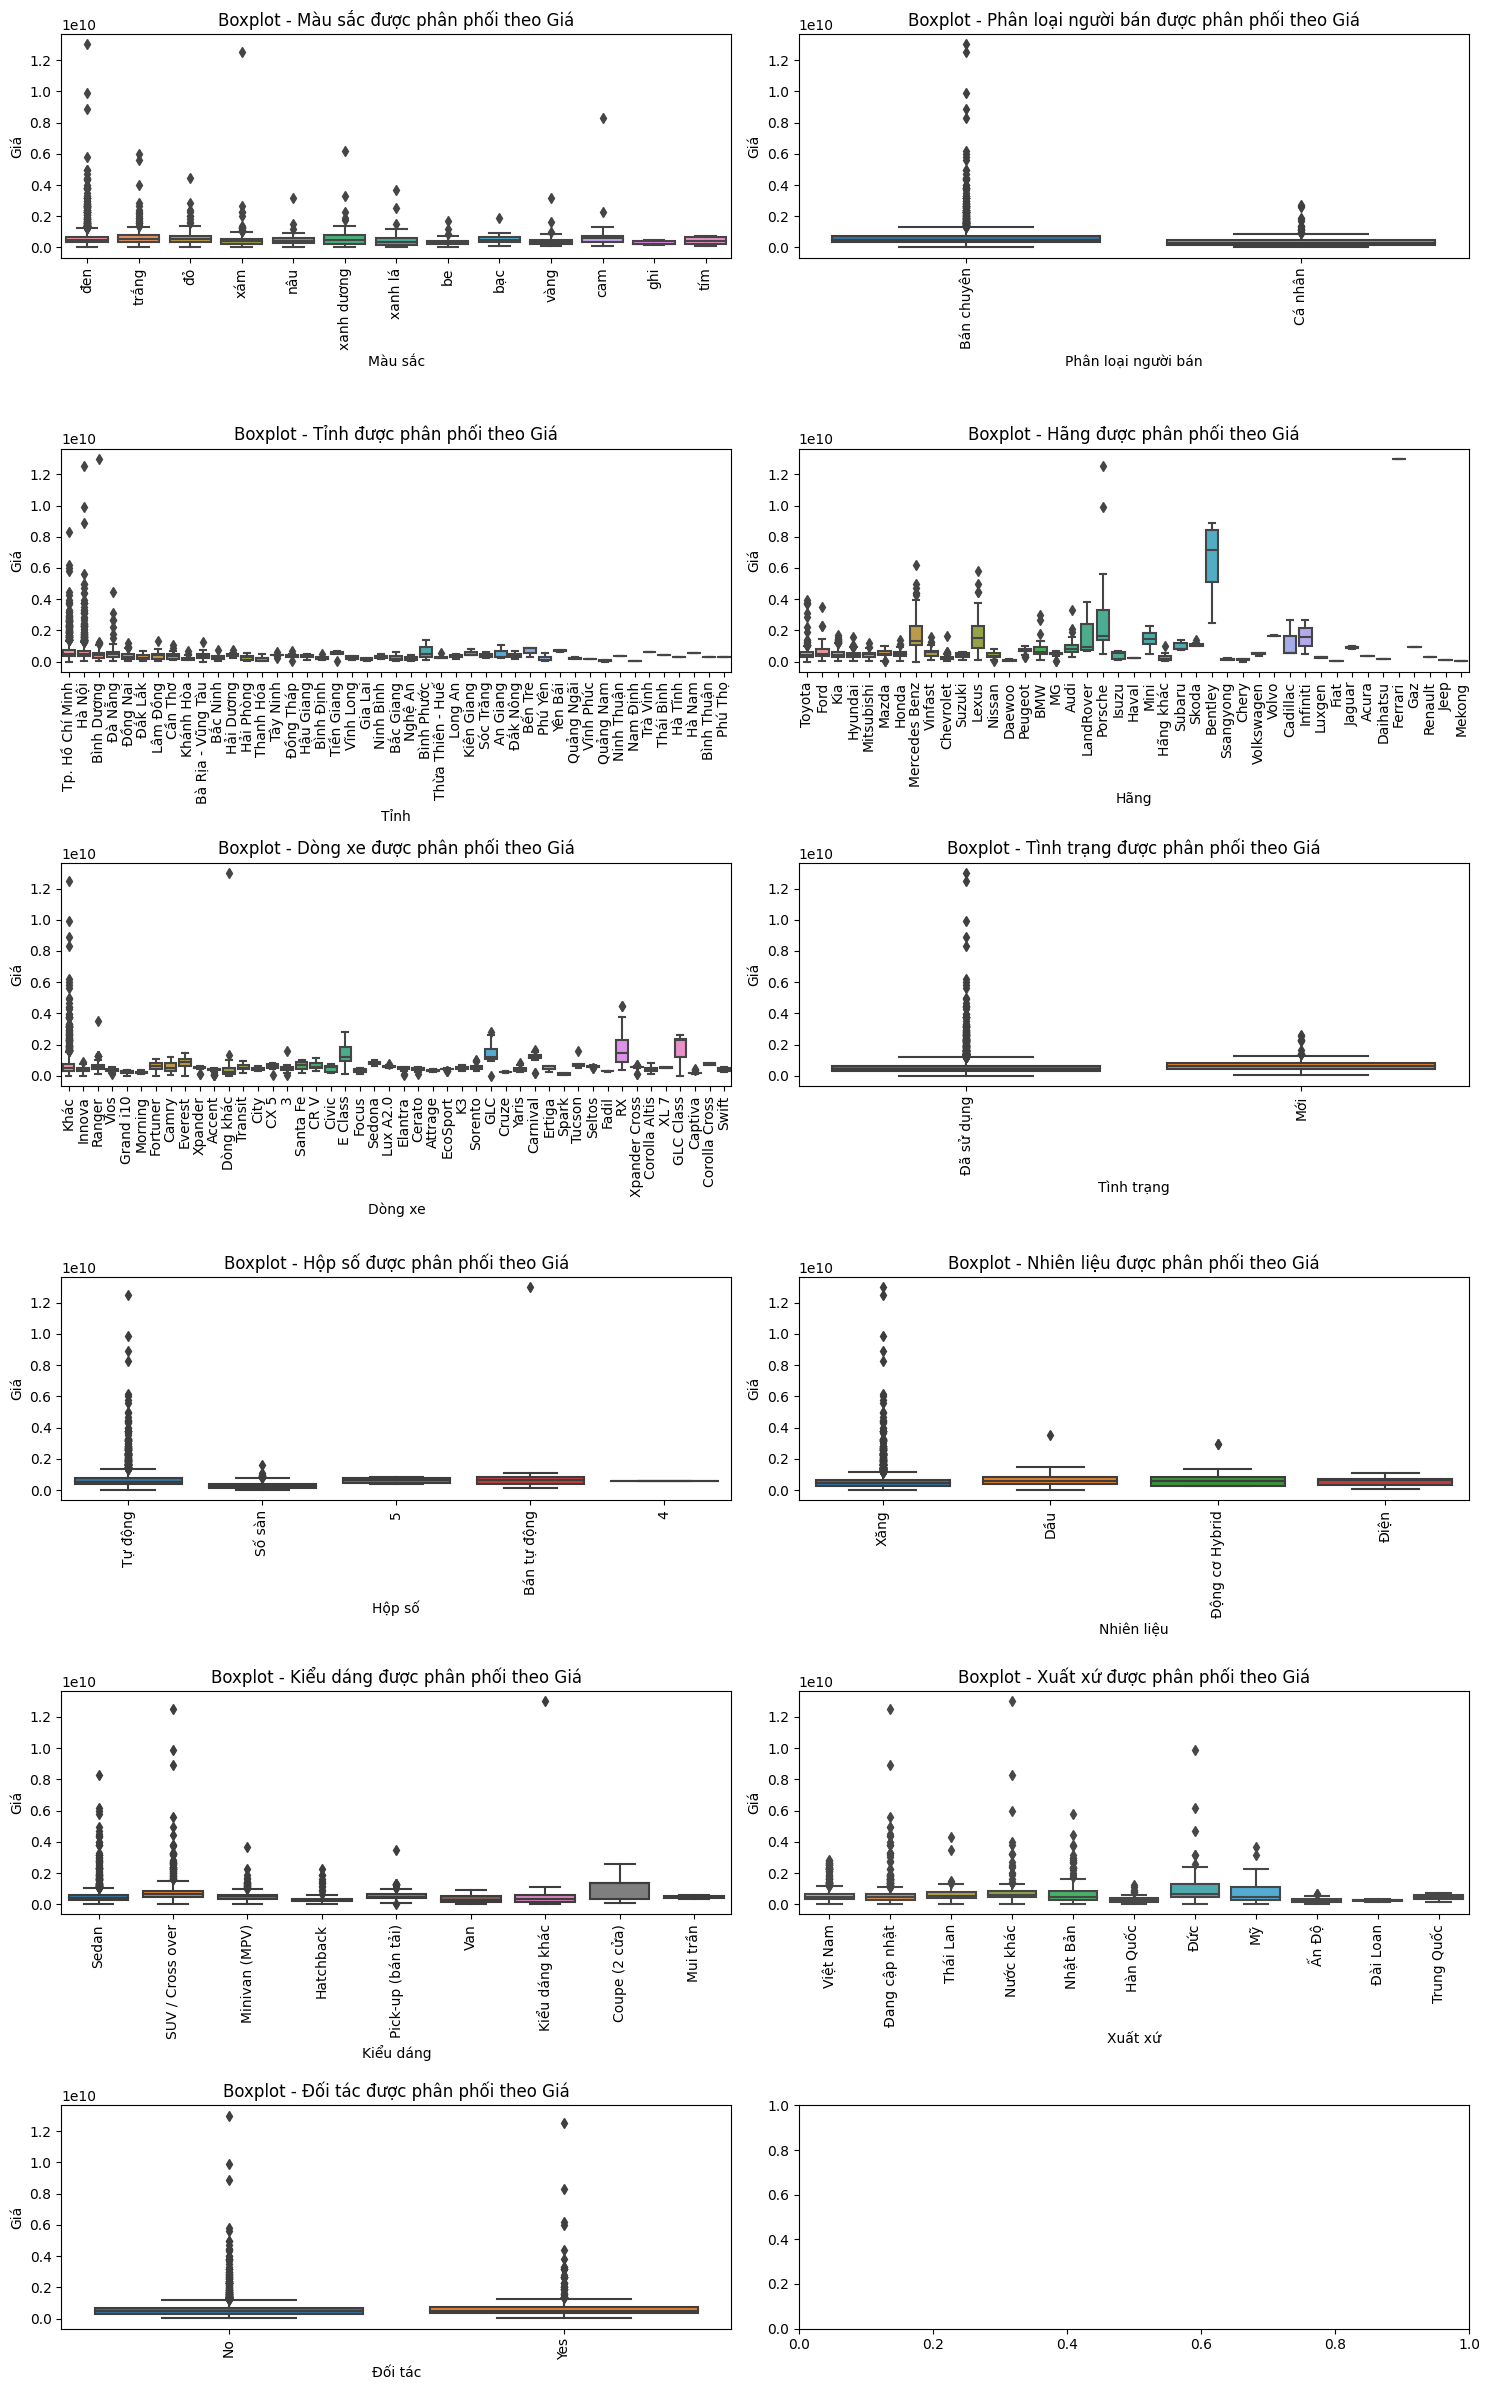

In [60]:
# Vẽ boxplot cho tất cả các biến phân loại
boxplot_for_all_categorical_variables(df, categories_cols, target_col, top_n=45)

## 4.2.&nbsp;Tìm biến phân loại có khả năng ảnh hưởng đến giá xe ít nhất và nhiều nhất

- F-test càng lớn cho ta biết có sự khác biệt giữa số lượng giữa các biến phân loại, tức là có sự chênh lệch càng lớn giữa số lượng các nhãn có trong biến phân loại đó và p-value sẽ cho ta biết giá trị F-test có ý nghĩa hay không.
- Dựa vào F-test và p-value, ta có được các nhận xét sau đây:
    - `Phân loại người bán` có khả năng ảnh hưởng đến `Giá` nhiều nhất do có F-test lớn nhất và p-value của nó là có ý nghĩa.
    - `Tỉnh` có khả năng ảnh hưởng ít nhất đến `Giá` do có F-test nhỏ nhất và p-value của nó cũng có ý nghĩa.
    - `Tình trạng`, `Đối tác` và `Nhiên liệu` có giá trị p-value không có ý nghĩa nên không thể đánh giá. Ta cũng có thể xem chúng có khả năng ảnh hưởng ít nhất đến `Giá`.
- Do đó, có thể kết luận rằng các biến phân loại đều có ảnh hưởng đến `Giá` ngoại trừ `Tình trạng`, `Đối tác` và `Nhiên liệu` vì chúng tôi không đủ cơ sở để đánh giá 3 thuộc tính này.

In [61]:
def find_most_influential_categorical_variable(df, category_columns, target_column):
    """
    Tìm biến phân loại ảnh hưởng nhiều nhất đến giá xe bằng F-test và p-value.

    Parameters:
    - df: DataFrame, dữ liệu.
    - category_columns: list, danh sách tên các cột biến phân loại.
    - target_column: str, tên cột biến mục tiêu (giá xe).

    Returns:
    - DataFrame, thông tin về biến phân loại ảnh hưởng nhiều nhất (tên, F-statistic, p-value).
    """
    results = []

    # Tạo bảng sao chép của DataFrame
    df_copy = df.copy()

    # Thay thế khoảng trắng bằng dấu _ trong tên các cột
    df_copy.columns = df_copy.columns.str.replace(' ', '_')

    for category_column in category_columns:
        formula = f"{target_column} ~ {category_column.replace(' ', '_')}"
        model = ols(formula, data=df_copy).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        f_statistic = anova_table['F'][0]
        p_value = anova_table['PR(>F)'][0]

        results.append({'Tên biến': category_column, 'F-statistic': f_statistic,
                       'p-value': p_value, 'Có ý nghĩa?': True if p_value < 0.05 else False})

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(
        by=['F-statistic', 'p-value'], ascending=[False, True]).reset_index(drop=True)

    return result_df

In [62]:
# Tạo dataframe chứa các giá trị đánh giá độ ảnh hưởng của các biến phân loại đến giá xe.
find_most_influential_categorical_variable(df, categories_cols, target_col)

,Tên biến,F-statistic,p-value,Có ý nghĩa?
0,Phân loại người bán,65.916356,7.091995e-16,True
1,Hãng,61.268111,0.000000e+00,True
2,Hộp số,47.544888,1.136839e-38,True
3,Dòng xe,17.332076,0.000000e+00,True
4,Kiểu dáng,15.549850,1.456315e-22,True
5,Xuất xứ,13.158782,8.830595e-23,True
6,Màu sắc,2.481895,3.126439e-03,True
7,Tình trạng,2.198160,1.382930e-01,False
8,Tỉnh,1.519547,1.566322e-02,True
9,Đối tác,0.896191,3.438904e-01,False


In [63]:
# Xóa các thuộc tính không có ý nghĩa
df.drop(columns=['Tình trạng', 'Đối tác', 'Nhiên liệu'], inplace=True)

## 4.3.&nbsp;Tìm biến số (mang giá trị phân loại) có khả năng ảnh hưởng đến giá xe ít nhất và nhiều nhất

- Do các biến kiểu số đều là kiểu số nguyên (int64) nên ta có thể xem các giá trị này như là các nhãn phân loại để đem đi phân tích với `Giá`.
- Dựa vào F-test và p-value, ta có được các nhận xét sau đây:
    - `Năm sản xuất` có khả năng ảnh hưởng đến `Giá` nhiều nhất do có F-test lớn nhất và p-value của nó là có ý nghĩa.
    - `Số Km đã đi` có khả năng ảnh hưởng ít nhất đến `Giá` do có F-test nhỏ nhất và p-value của nó cũng có ý nghĩa.
    - `Số chỗ` có giá trị p-value không có ý nghĩa nên không thể đánh giá. Ta cũng có thể xem chúng có khả năng ảnh hưởng ít nhất đến `Giá`.
- Do đó, có thể kết luận rằng các biến số đều có ảnh hưởng đến `Giá` ngoại trừ `Số chỗ` vì chúng tôi không đủ cơ sở để đánh giá thuộc tính này.

In [64]:
# Tạo dataframe chứa các giá trị đánh giá độ ảnh hưởng của 
# các biến số (chứa các giá trị rời rạc) đến giá xe.
find_most_influential_categorical_variable(df, numeric_cols, target_col)

,Tên biến,F-statistic,p-value,Có ý nghĩa?
0,Năm sản xuất,195.091311,7.510691e-43,True
1,Số Km đã đi,108.992618,4.882007e-25,True
2,Số chỗ,0.168265,6.816915e-01,False


In [65]:
# Xóa các thuộc tính không có ý nghĩa
df.drop(columns=['Số chỗ'], inplace=True)

# 5.&nbsp;Tìm `Dòng xe` rao báo ở `Tỉnh` nào thì có `Giá` trung bình cao nhất

Sau khi tiến hành phân tích nhóm cho `Dòng xe` và `Tỉnh` thì chúng tôi rút ra được kết luận như sau:
- Tỉnh có giá trung bình cao nhất là Hà Nội.
- Dòng xe có giá trung bình cao nhất ở Hà Nội là Panamera với 12.5 tỷ đồng.
- Dòng xe có giá trung bình thấp nhất ở Hà Nội là CD5 với 56 triệu đồng. 

In [66]:
# Nhóm dữ liệu theo "Dòng xe" và "Tỉnh" rồi tính giá trung bình
grouped_data = df.groupby(['Dòng xe', 'Tỉnh'])['Giá'].mean().reset_index()

# Tìm tỉnh có giá trung bình cao nhất
max_price_province_name = grouped_data.groupby('Tỉnh')['Giá'].mean().idxmax()

# Chọn ra các dòng xe thuộc tỉnh có giá trung bình cao nhất và sắp xếp theo giá giảm dần
max_price_province_df = grouped_data.loc[grouped_data['Tỉnh'] == max_price_province_name]\
    .sort_values(by='Giá', ascending=False).reset_index(drop=True)

# In kết quả
print("Tỉnh có giá trung bình cao nhất là:", max_price_province_name)
print("Dòng xe và giá trung bình tương ứng là:")
max_price_province_df[['Dòng xe', 'Giá']]

Tỉnh có giá trung bình cao nhất là: Hà Nội
Dòng xe và giá trung bình tương ứng là:


,Dòng xe,Giá
0,Panamera,1.250000e+10
1,911,9.900000e+09
2,Mulsanne,8.900000e+09
3,Maybach,3.847250e+09
4,GLS Class,3.790000e+09
...,...,...
157,Lacetti,1.421429e+08
158,Gentra,1.300000e+08
159,Premacy,1.150000e+08
160,Matiz,6.200000e+07


# 6.&nbsp;Lưu bộ dữ liệu sau khi EDA

In [67]:
# Thông tin các thuộc tính sau khi EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Màu sắc              2685 non-null   object
 1   Phân loại người bán  2685 non-null   object
 2   Tỉnh                 2685 non-null   object
 3   Hãng                 2685 non-null   object
 4   Dòng xe              2685 non-null   object
 5   Năm sản xuất         2685 non-null   int64 
 6   Số Km đã đi          2685 non-null   int64 
 7   Hộp số               2685 non-null   object
 8   Kiểu dáng            2685 non-null   object
 9   Xuất xứ              2685 non-null   object
 10  Giá                  2685 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 230.9+ KB


In [68]:
# Hiển thị 5 dòng đầu tiên của bộ dữ liệu
df.head()

,Màu sắc,Phân loại người bán,Tỉnh,Hãng,Dòng xe,Năm sản xuất,Số Km đã đi,Hộp số,Kiểu dáng,Xuất xứ,Giá
0,đen,Bán chuyên,Hà Nội,Mitsubishi,Xpander,2022,50000,Tự động,Minivan (MPV),Đang cập nhật,559000000
1,nâu,Cá nhân,Tp. Hồ Chí Minh,Nissan,Sunny,2019,52000,Tự động,Sedan,Hàn Quốc,335000000
2,đen,Cá nhân,Tp. Hồ Chí Minh,Ford,Escape,2003,50000,Tự động,SUV / Cross over,Việt Nam,106000000
3,đen,Cá nhân,Tp. Hồ Chí Minh,Hyundai,Accent,2021,42,Tự động,Sedan,Hàn Quốc,450000000
4,đỏ,Bán chuyên,Hà Nội,Ford,Ranger,2022,51000,Tự động,SUV / Cross over,Việt Nam,534000000


## 6.1.&nbsp;Bộ dữ liệu gốc

In [69]:
# Lưu bộ dữ liệu đã được tiền xử lý ở định dạng csv với tên là 'CarPricePrediction_Clean.csv'
df.to_csv('../data/CarPricePrediction_Clean.csv', index=False)

In [70]:
# Lấy danh sách các cột có kiểu dữ liệu là object (có thể là biến phân loại)
categorical_columns = df.select_dtypes(include=['object']).columns

## 6.2.&nbsp;Bộ dữ liệu dùng Label Encoder

In [71]:
# Tạo một bản sao của DataFrame df và lưu vào df_label
df_label = df.copy()

# Áp dụng Label Encoding cho từng cột phân loại
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_label[col] = label_encoder.fit_transform(df_label[col])

In [72]:
# Lưu bộ dữ liệu đã được tiền xử lý ở định dạng csv với tên là 'CarPricePrediction_Label.csv'
df_label.to_csv('../data/CarPricePrediction_Label.csv', index=False)

## 6.3.&nbsp;Bộ dữ liệu dùng One Hot Encoder

In [73]:
# Tạo một bản sao của DataFrame df và lưu vào df_onehot
df_onehot = df.copy()

# Áp dụng One-Hot Encoding cho các cột dạng categorical trong DataFrame
df_onehot = pd.get_dummies(df_onehot, prefix=categorical_columns)

# Lấy cột 'Giá' và lưu vào biến 'price'
price = df_onehot.pop('Giá')

# Thêm cột 'Giá' vào cuối DataFrame
df_onehot['Giá'] = price

In [74]:
# Lưu bộ dữ liệu đã được tiền xử lý ở định dạng csv với tên là 'CarPricePrediction_OneHot.csv'
df_onehot.to_csv('../data/CarPricePrediction_OneHot.csv', index=False)